# Install Selenium

Make sure Python 3 is installed and run (or use anaconda):
```bash
pip3 install selenium
```
### Install a browser driver. 

For Chrome, run:
```bash
brew install --cask chromedriver
```
For Firefox, run:
```bash
brew install geckodriver
```

In [56]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC

import sqlite3

import pandas as pd
from io import StringIO

import matplotlib.pyplot as plt

### Script

We can't separate the scripts into smaller ones. From webdriver instantiation to driver quit it has to be on the same code block.

1. Go to https://www.windguru.cz/archive.php
2. Type `Madagascar - Anakao` into the search bar, then ENTER
3. Prompted for login
4. Use `my-name:qwerty` then submit
5. Select `1 hour`
6. Select `Wind speed`, `Temperature`, `Rain (mm/1h)`
7. Click on `Go`
8. Search for the forecast table which will have the data

In [22]:
driver = webdriver.Chrome()
driver.get("https://www.windguru.cz/archive.php")

data_html = ""

try:
    wait = WebDriverWait(driver, 10)

    # Select Spot
    input_box = wait.until(EC.presence_of_element_located((By.ID, "searcharch")))
    input_box.send_keys("Madagascar - Anakao")
    input_box.send_keys(Keys.ENTER)

    # Login
    username_input = wait.until(EC.presence_of_element_located((By.NAME, "username")))
    username_input.send_keys("my-name")
    
    password_input = wait.until(EC.presence_of_element_located((By.NAME, "password")))
    password_input.send_keys("qwerty")

    submit_btn = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "button[type='submit']")))
    submit_btn.click()

    wait.until(EC.invisibility_of_element_located((By.ID, "jBoxID37")))
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "table.forecast.daily-archive")))
    
    # Configurations
    date_from = wait.until(EC.presence_of_element_located((By.ID, "date_from")))
    driver.execute_script("arguments[0].setAttribute('value', '2024-01-01')", date_from)
    
    date_to = wait.until(EC.presence_of_element_located((By.ID, "date_to")))
    driver.execute_script("arguments[0].setAttribute('value', '2024-12-31')", date_to)
    
    step_select_element = wait.until(EC.presence_of_element_located((By.NAME, "step")))
    step_select = Select(step_select_element)
    step_select.select_by_visible_text("1 hour")

    WebDriverWait(driver, 10, 1, (StaleElementReferenceException)).until(lambda driver: driver.find_element(By.XPATH, "//label[input[@value='APCP1']]").click() or True)

    label = wait.until(EC.presence_of_element_located((By.XPATH, "//label[input[@value='WINDDIR']]")))
    label.click()

    go_btn = wait.until(EC.element_to_be_clickable((By.XPATH, "//button[@type='button' and contains(text(), 'Go')]")))
    go_btn.click()

    # Get the data
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "table.forecast.daily-archive")))
    data_html = driver.page_source

finally:
    driver.quit()

## Clean the data
Use Pandas to clean the data

In [24]:

df = pd.read_html(StringIO(data_html))[1]

df.columns = pd.MultiIndex.from_arrays([df.iloc[0], df.iloc[1]])
df = df.iloc[2:].reset_index(drop=True)

df = df.set_index(df.columns[0])

df.head()

0                      Wind speed (knots)                                      \
1                                     00h 01h 02h 03h 04h 05h 06h 07h 08h 09h   
(GFS 13 km, GFS 13 km)                                                          
01.01.2024                              8   8   8   8   8   8   5   8  11  11   
02.01.2024                             13  14  13  12  11  12  13  14  14  15   
03.01.2024                             14  13  14  12  12  12  11  11  10   6   
04.01.2024                             10  10   9   9  10   9   9   9   7   2   
05.01.2024                             10  11  10   9   9  10   9   9   7   7   

0                       ... Rain (mm/1h)                                     \
1                       ...          14h  15h  16h  17h  18h  19h  20h  21h   
(GFS 13 km, GFS 13 km)  ...                                                   
01.01.2024              ...          NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.4   
02.01.2024              ...          0.2  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
03.01.2024              ...          0.4  0.3  0.3  0.5  0.6  0.4  0.3  NaN   
04.01.2024              ...          NaN  NaN  NaN  0.1  0.5  0.6  0.1  NaN   
05.01.2024              ...          NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.1   

0                                 
1                       22h  23h  
(GFS 13 km, GFS 13 km)            
01.01.2024              0.1  NaN  
02.01.2024              NaN  NaN  
03.01.2024              NaN  NaN  
04.01.2024              NaN  NaN  
05.01.2024              0.4  NaN  

[5 rows x 72 columns]

## Store data to SQLite
I will use sqlite3 connection for this. <br/>
We need to flatten the multi-index first.

In [26]:
with sqlite3.connect('weather_archive.db') as conn:
    if isinstance(df.columns, pd.MultiIndex):
        cols = ['_'.join(col).strip() for col in df.columns.to_flat_index()]
        df.columns = cols
    
    df.to_sql('mada_anakao_2024', conn, if_exists='replace', index=True)

## View Data

We will use pandas `read_sql` to get our data from database

In [44]:
with sqlite3.connect('weather_archive.db') as conn:

    df_sql = pd.read_sql('SELECT * FROM mada_anakao_2024', conn)
    
    tuples = [tuple(col.split('_')) for col in df_sql.columns]
    df_sql.columns = pd.MultiIndex.from_tuples(tuples, names=['Feature', 'Time'])
    df_sql = df_sql.set_index(df_sql.columns[0])

    df_sql = df_sql.apply(pd.to_numeric)

df_sql.head()

Feature                           Wind speed (knots)                          \
Time                                             00h 01h 02h 03h 04h 05h 06h   
(('GFS 13 km', 'GFS 13 km'), nan)                                              
01.01.2024                                         8   8   8   8   8   8   5   
02.01.2024                                        13  14  13  12  11  12  13   
03.01.2024                                        14  13  14  12  12  12  11   
04.01.2024                                        10  10   9   9  10   9   9   
05.01.2024                                        10  11  10   9   9  10   9   

Feature                                        ... Rain (mm/1h)            \
Time                              07h 08h 09h  ...          14h  15h  16h   
(('GFS 13 km', 'GFS 13 km'), nan)              ...                          
01.01.2024                          8  11  11  ...          NaN  NaN  NaN   
02.01.2024                         14  14  15  ...          0.2  NaN  NaN   
03.01.2024                         11  10   6  ...          0.4  0.3  0.3   
04.01.2024                          9   7   2  ...          NaN  NaN  NaN   
05.01.2024                          9   7   7  ...          NaN  NaN  NaN   

Feature                                                              
Time                               17h  18h  19h  20h  21h  22h 23h  
(('GFS 13 km', 'GFS 13 km'), nan)                                    
01.01.2024                         NaN  NaN  NaN  NaN  0.4  0.1 NaN  
02.01.2024                         NaN  NaN  NaN  NaN  NaN  NaN NaN  
03.01.2024                         0.5  0.6  0.4  0.3  NaN  NaN NaN  
04.01.2024                         0.1  0.5  0.6  0.1  NaN  NaN NaN  
05.01.2024                         NaN  NaN  NaN  NaN  0.1  0.4 NaN  

[5 rows x 72 columns]

## Play with data

What is the min, max temp of Anakao in 2024?

In [30]:
(df_sql['Temperature (°C)'].min().min(), df_sql['Temperature (°C)'].max().max())

('16', '33')

What is the mean temperature of Anakao in 2024?

In [50]:
df_sql['Temperature (°C)'].mean().mean()

25.116234061930783

Plot Anakao's Temperature of 2024

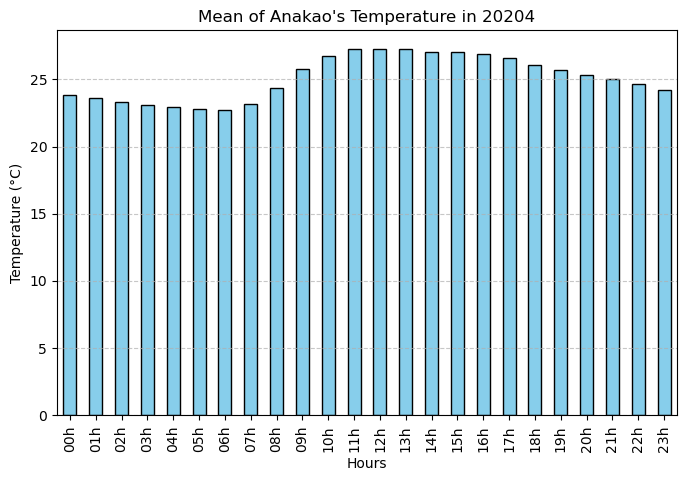

In [58]:
mean_values = df_sql['Temperature (°C)'].mean()

mean_values.plot(kind='bar', figsize=(8, 5), color='skyblue', edgecolor='black')

plt.xlabel("Hours")
plt.ylabel("Temperature (°C)")
plt.title("Mean of Anakao's Temperature in 20204")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()